In [3]:
import pandas as pd 

B1 = pd.read_csv('../MNN2017/Simulations/unique_B1_original.csv').to_numpy().T
B2i = pd.read_csv('../MNN2017/Simulations/unique_B2i_original.csv').to_numpy().T
B2ii = pd.read_csv('../MNN2017/Simulations/unique_B2ii_original.csv').to_numpy().T
clust2i = pd.read_csv('../MNN2017/Simulations/unique_clust2i.csv').to_numpy().reshape(1000,)
clust2ii = pd.read_csv('../MNN2017/Simulations/unique_clust2ii.csv').to_numpy().reshape(1000,)
clust1 = pd.read_csv('../MNN2017/Simulations/unique_clust1.csv').to_numpy().reshape(1000,)


In [4]:
p = 20

In [5]:
import numpy
def CCA(X1, X2, k):
    r1 = 1e-4
    r2 = 1e-4

    n1 = X1.shape[1] 
    n2 = X2.shape[1]
    m = X1.shape[0] #number of rows

    mean1 = numpy.mean(X1, axis=0)
    mean2 = numpy.mean(X2, axis=0)

    H1bar = X1 - numpy.tile(mean1, (m, 1))
    H2bar = X2 - numpy.tile(mean2, (m, 1))


    SigmaHat12 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H2bar)
    SigmaHat11 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H1bar) + r1 * numpy.identity(n1)
    SigmaHat22 = (1.0 / (m - 1)) * numpy.dot(H2bar.T, H2bar) + r2 * numpy.identity(n2)


    [D1, V1] = numpy.linalg.eigh(SigmaHat11) #Eigendecomposition for easy inversion
    [D2, V2] = numpy.linalg.eigh(SigmaHat22) #Eigendecomposition for easy inversion
    SigmaHat11RootInv = numpy.dot(numpy.dot(V1, numpy.diag(D1 ** -0.5)), V1.T) #
    SigmaHat22RootInv = numpy.dot(numpy.dot(V2, numpy.diag(D2 ** -0.5)), V2.T)
    T = numpy.dot(numpy.dot(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)
    

    [U, D, V] = numpy.linalg.svd(T)
    V = V.T
    A1star = numpy.dot(SigmaHat11RootInv, U[:, 0:k])
    A2star = numpy.dot(SigmaHat22RootInv, V[:, 0:k])
    D = D[0:k]

    top_k_singular_values = D[:k]

    total_corr = numpy.sum(D)

    return A1star, total_corr, A2star

In [6]:
import numpy as np 
def l2_norm(in_matrix):
    return np.linalg.norm(x=in_matrix, axis=0)


def scale_columns(in_matrix, scale_vector):
    return np.divide(in_matrix, scale_vector)


In [7]:
view1 = scale_columns(B1, l2_norm(B1))
view2 = scale_columns(B2i, l2_norm(B2i))

In [8]:
A1, total_corr, A2 = CCA(view1, view2, k=p)

result1 = view1 @ A1
result2 = view2 @ A2

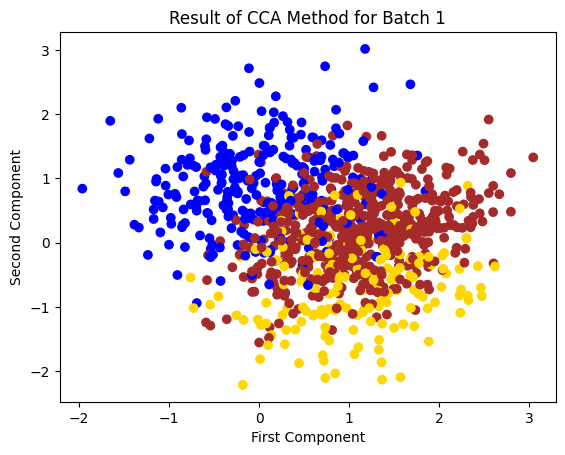

In [9]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.scatter(result1[:, 0], result1[:, 1], c=clust1)

# Adding title and axis labels
plt.title('Result of CCA Method for Batch 1')
plt.xlabel('First Component')
plt.ylabel('Second Component')



# Displaying the plot
plt.savefig(f'p={p}/diff_comp_batch1.png')

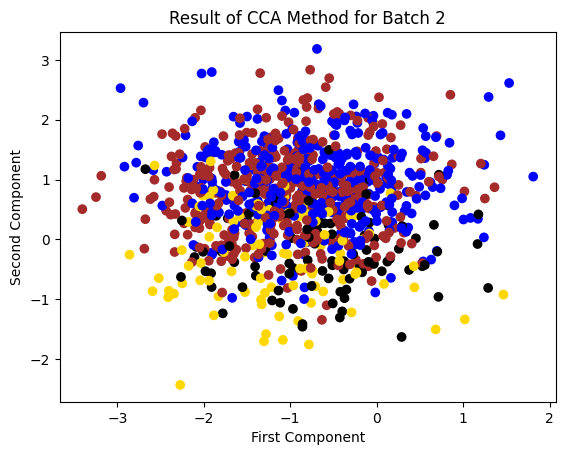

In [10]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.scatter(result2[:, 0], result2[:, 1], c=clust2i)

# Adding title and axis labels
plt.title('Result of CCA Method for Batch 2')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Displaying the plot
plt.savefig(f'p={p}/diff_comp_batch2.png')

In [11]:
import numpy as np
np.unique(clust1, return_counts=True)

(array(['blue', 'brown', 'gold'], dtype=object), array([282, 540, 178]))

In [12]:
np.unique(clust2i, return_counts=True)

(array(['black', 'blue', 'brown', 'gold'], dtype=object),
 array([102, 379, 418, 101]))

### MNN

In [13]:
import numpy as np 
def l2_norm(in_matrix):
    return np.linalg.norm(x=in_matrix, axis=0)


def scale_columns(in_matrix, scale_vector):
    return np.divide(in_matrix, scale_vector)


In [14]:
ref_batch_in = scale_columns(result1, l2_norm(result1))
new_batch_in = scale_columns(result2, l2_norm(result2))

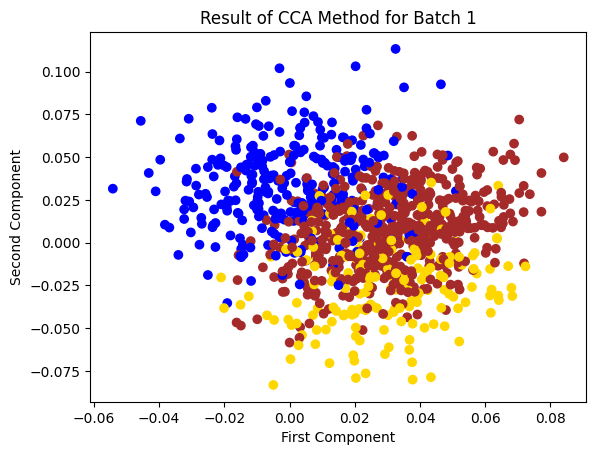

In [15]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.scatter(ref_batch_in[:, 0], ref_batch_in[:, 1], c=clust1)

# Adding title and axis labels
plt.title('Result of CCA Method for Batch 1')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Displaying the plot
plt.savefig(f'p={p}/diff_comp_batch2.png')

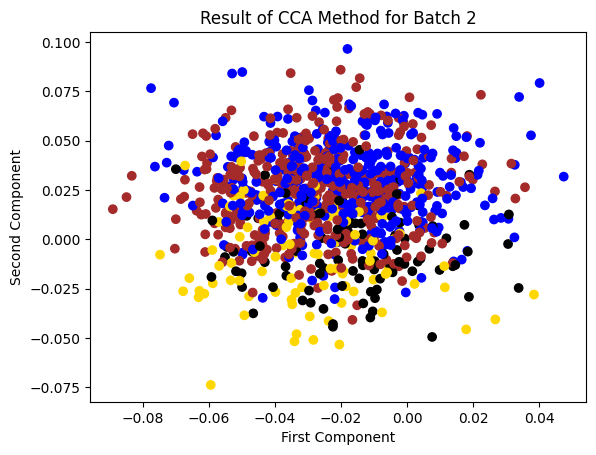

In [16]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.scatter(new_batch_in[:, 0], new_batch_in[:, 1], c=clust2i)

# Adding title and axis labels
plt.title('Result of CCA Method for Batch 2')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Displaying the plot
plt.savefig(f'p={p}/diff_comp_batch2.png')

In [17]:
from scipy.spatial import cKDTree

def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    k_index_1 = cKDTree(data1).query(x=data2, k=k1, workers=n_jobs)[1]
    k_index_2 = cKDTree(data2).query(x=data1, k=k2, workers=n_jobs)[1]
    mutual_1 = []
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
        for index_1 in k_index_1[index_2]:
            if index_2 in k_index_2[index_1]:
                mutual_1.append(index_1)
                mutual_2.append(index_2)
    return mutual_1, mutual_2

k = 10
n_jobs = 5
mnn_ref, mnn_new = find_mutual_nn(data1=ref_batch_in,
                                  data2=new_batch_in, k1=k, k2=k,  n_jobs=n_jobs)

In [18]:
import numpy as np

def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    #w
    B = data1[mnn1] - data2[mnn2]
    mnn_index, mnn_count = np.unique(mnn2, return_counts=True)
    vect_reduced = np.zeros((data2.shape[0], B.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, B):
        vect_reduced[index] += ve
    vect_avg = np.divide(vect_reduced[mnn_index], mnn_count.astype(np.float32)[:, None])
    #D_c_i
    exp_distance = np.exp(-kdist(data2_or_raw2, data2_or_raw2[mnn_index]) / sigma)
    density = np.sum(exp_distance[mnn_index], axis=0)
    mult = np.divide(exp_distance, density)
    total_prob = np.sum(mult, axis=1, keepdims=True)
    output = np.dot(mult, vect_avg)

    return np.divide(output, total_prob)

In [19]:
def kdist(m, n):
    dist = np.zeros((m.shape[0], n.shape[0]), dtype=np.float32)
    for i in range(m.shape[0]):
        for j in range(n.shape[0]):
            dist[i, j] = np.dot(m[i], n[j])
    return dist

In [20]:
ref_batch_in = scale_columns(B1, l2_norm(B1))
new_batch_in = scale_columns(B2i, l2_norm(B2i))

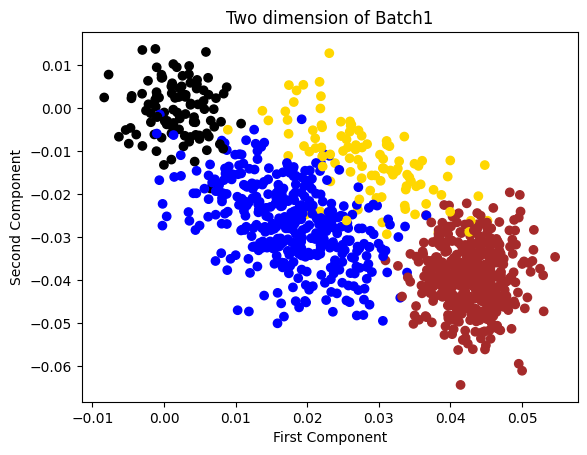

In [30]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.scatter(new_batch_in[:, 0], new_batch_in[:, 1], c=clust2i)

# Adding title and axis labels
plt.title('Two dimension of Batch1')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Displaying the plot
plt.savefig(f'p={p}/diff_comp_batch2.png')

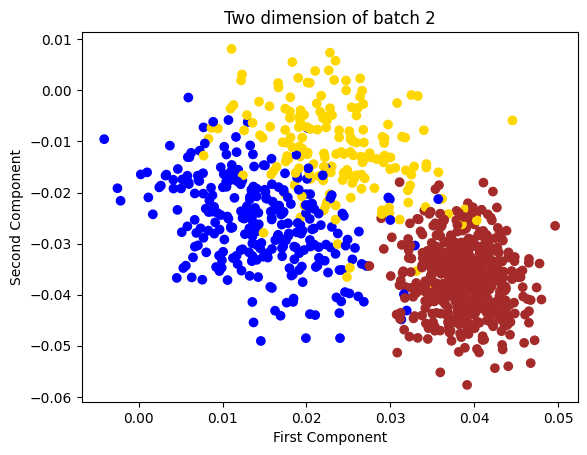

In [31]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.scatter(ref_batch_in[:, 0], ref_batch_in[:, 1], c=clust2ii)

# Adding title and axis labels
plt.title('Two dimension of batch 2')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Displaying the plot
plt.savefig(f'p={p}/diff_comp_batch2.png')

In [23]:
sigma = 1
correction_in = compute_correction(ref_batch_in, new_batch_in, mnn_ref, mnn_new,
                                           new_batch_in, sigma)

In [24]:
clus = np.concatenate((clust1, clust2i))

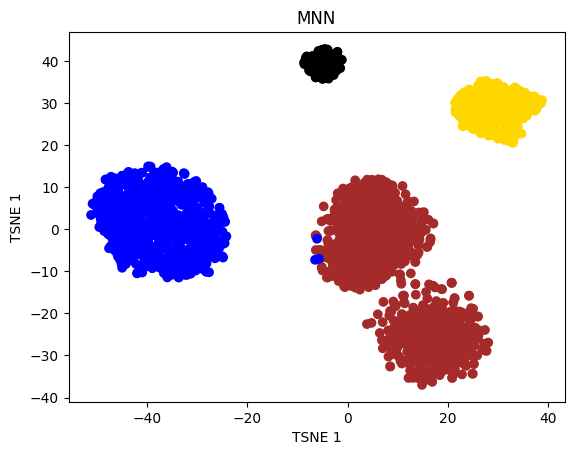

In [25]:
conc = np.concatenate((ref_batch_in, new_batch_in + correction_in), axis=0)
from sklearn.manifold import TSNE

embedding1 = TSNE(n_components=2, perplexity=30).fit_transform(conc)

import matplotlib.pyplot as plt

plt.scatter(embedding1[:, 0], embedding1[:, 1], c=clus)
# Adding title and axis labels
plt.title('MNN')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 1')

# Displaying the plot
plt.savefig(f'p={p}/the_diff_tsne_mnn.png')

# Clusters

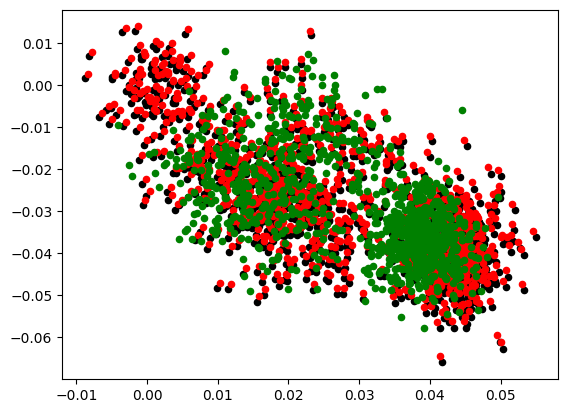

In [26]:
plt.scatter((new_batch_in + correction_in)[:, 0], (new_batch_in + correction_in)[:, 1], marker='o', s=20, c='black')
plt.scatter((new_batch_in)[:, 0], (new_batch_in)[:, 1], marker='o', s=20, c='red')
plt.scatter((ref_batch_in)[:, 0], (ref_batch_in)[:, 1], marker='o', s=20, c='green')

In [27]:
conc = np.concatenate((B1, B2i), axis=0)

In [28]:
from sklearn.manifold import TSNE

embedding2 = TSNE(n_components=2, learning_rate='auto',
         init='random', perplexity=50).fit_transform(conc)


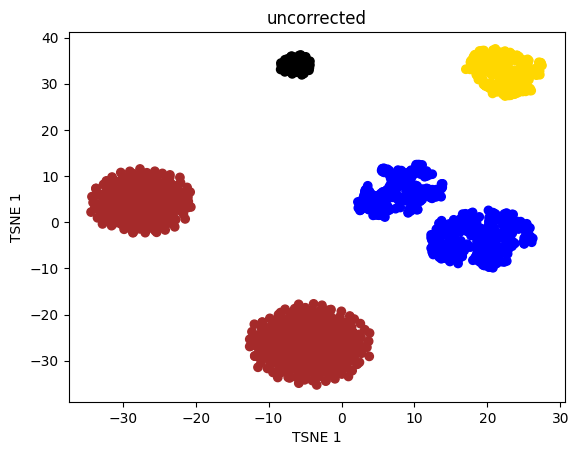

In [29]:
import matplotlib.pyplot as plt

plt.scatter(embedding2[:, 0], embedding2[:, 1], c=clus)
# Adding title and axis labels
plt.title('uncorrected')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 1')

# Displaying the plot
plt.savefig(f'p={p}/the_diff_tsne.png')